In [87]:
import numpy as np
import lmfit
import matplotlib.pyplot as plt
plt.style.use("seaborn-colorblind")

# Data

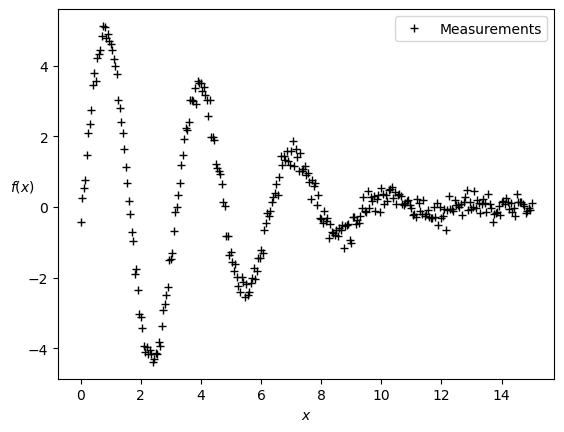

In [88]:
# create data to be fitted (we construct it in such a way that it does follow this model, just with noise)
x = np.linspace(0, 15, 301)
noise = np.random.normal(size=len(x), scale=0.2)
data = 5.0 * np.sin(2*x - 0.1) * np.exp(-x*x*0.025) + noise


plt.plot(x, data, 'k+',label="Measurements")
plt.ylabel(r"$f(x)$", rotation=0)
plt.xlabel(r"$x$")
plt.legend()
plt.show()

# Model
Lets say we measure data (amplitude of a certain oscillator over time perhaps) and wish to model it with a function we have determined to be appropriate

$$ f(x) = A\sin(\omega x + \delta) e^{-\lambda x^2} $$

**Known:**
- $f$ is the function we measure (we may know a collection of values of $f$, called $\{f_i\}$ at values of the independent variable $\{x_i\}$)
- $x$ is the independent variable, such as time in the case of measuring the amplitude of an oscillator

**Unknown:** (parameters in the model)
- $A\longrightarrow$  An amplitude
- $\omega\longrightarrow$ An oscillation frequency
- $\delta\longrightarrow$ An offset or "shift"
- $\lambda\longrightarrow$ A decay

In [89]:
# (there is a nicer looking way to define models presented in example 2)

# define objective function: returns the array to be minimized. lmfit expects a function that returns the residual between data and model
def model_data_difference(params, x, data): # make sure params is first, and the other arguments will be passed by "fcn_args" in the minimizer
    """Model a decaying sine wave and subtract data."""
    amp = params['amp']
    shift = params['shift']
    omega = params['omega']
    decay = params['decay']

    model = amp * np.sin(x*omega + shift) * np.exp(-x*x*decay)
    return model - data


# create a set of Parameters
params = lmfit.Parameters()
params.add('amp', value=10, min=0)
params.add('decay', value=0.1)
params.add('shift', value=0.0, min=-np.pi/2., max=np.pi/2)
params.add('omega', value=3.0)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 59
    # data points      = 301
    # variables        = 4
    chi-square         = 10.8771614
    reduced chi-square = 0.03662344
    Akaike info crit   = -991.453933
    Bayesian info crit = -976.625492
[[Variables]]
    amp:    4.98830605 +/- 0.03771090 (0.76%) (init = 10)
    decay:  0.02467050 +/- 4.2629e-04 (1.73%) (init = 0.1)
    shift: -0.09584606 +/- 0.00972528 (10.15%) (init = 0)
    omega:  1.99991178 +/- 0.00308387 (0.15%) (init = 3)
[[Correlations]] (unreported correlations are < 0.100)
    C(shift, omega) = -0.786
    C(amp, decay)   = 0.584
    C(amp, shift)   = -0.118


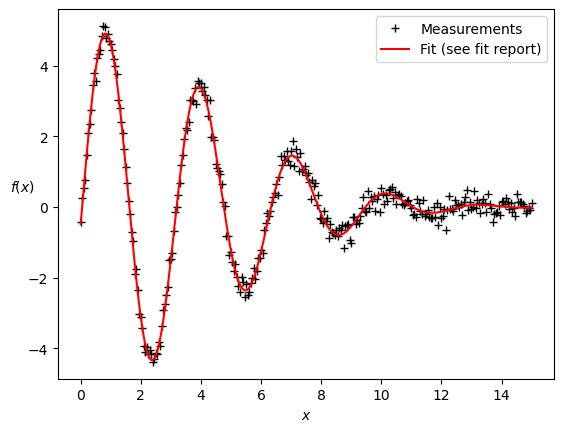

In [90]:
# do fit, here with leastsq model
minimizer_instance = lmfit.Minimizer(model_data_difference, params, fcn_args=(x, data))
result = minimizer_instance.minimize()

# calculate final result
final = data + result.residual  # after minimizing, residual = final model estimate - real data

# write error report
lmfit.report_fit(result)

#plot results
plt.plot(x, data, 'k+', label = "Measurements")
plt.plot(x, final, 'r', label = f"Fit (see fit report)")
plt.ylabel(r"$f(x)$", rotation=0)
plt.xlabel(r"$x$")
plt.legend()
plt.show()

# Second Example - binned data

#### Make data

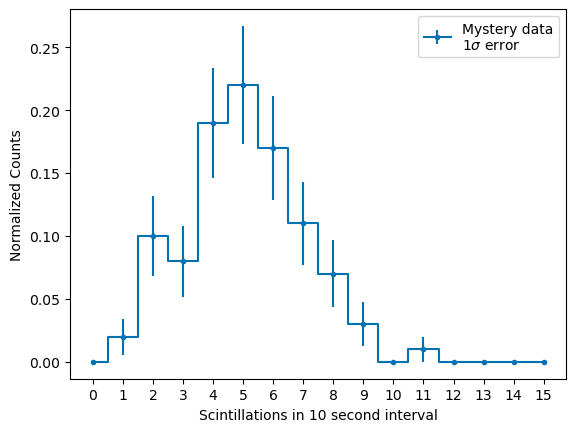

In [246]:
num_data_points = 100
mystery_data = np.random.normal(5.0,2.0,num_data_points) #np.random.poisson(5, 100)

max_bin = 15
offset = 0.5
bin_centers = np.arange(0, max_bin + 1, 1)
bin_edges = bin_centers - offset
bin_edges = np.append(bin_edges, max_bin + offset) # add in the last (rightmost) edge
bin_width = bin_centers[1] - bin_centers[0]
normalizing_factor = 1/(num_data_points * bin_width) # The factor that makes the area under the histogram be 1


counts, _ = np.histogram(mystery_data, bins=bin_edges)
normalized_counts = normalizing_factor*counts

counting_errors = np.sqrt(counts)
normalized_counting_errors = counting_errors * normalizing_factor 

plt.errorbar(bin_centers,
            normalized_counts,
            yerr=normalized_counting_errors,
            marker='.',
            drawstyle = 'steps-mid',
            label= "Mystery data\n" + r"$1\sigma$ error"
            )

plt.xlabel("Scintillations in 10 second interval")
plt.xticks(bin_centers)
plt.ylabel("Normalized Counts")
plt.legend()
plt.show()

#### Define model (Gaussian)

In [253]:
from scipy.stats import norm, chi2 # normal distribution, chi squared distribution
from numpy import exp, pi, sqrt

def Gaussian(x, amp, cen, sigma):
    """1-d gaussian: gaussian(x, amp, cen, sigma)"""
    return (amp / (sqrt(2*pi) *sigma)) * exp(-(x-cen)**2 / (2*sigma**2))

gmodel = lmfit.Model(Gaussian)

We can perform a weighted sum to calculate the model - data residual, and use that with lmfits minimization schemes. The weighting is 
$$\chi ^2 = \sum_{\text{bin } i} \frac{(\text{data}_i - \text{model}_i)^2}{\sigma _i^2} $$
where $\sigma_i$ is the error for the $i^{th}$ data point. This weights very uncertain points with less significance than very confident points. 

In lmfit we provide a function describing (data - model) at a point, and can also provide the weights via the "weights" parameter of the .fit() method, as below. The weights here are $1/\sigma_i$

#### Perform the fit

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 17
    # data points      = 16
    # variables        = 3
    chi-square         = 4.41698276
    reduced chi-square = 0.33976790
    Akaike info crit   = -14.5941103
    Bayesian info crit = -12.2763441
[[Variables]]
    amp:    0.97644463 +/- 0.05863166 (6.00%) (init = 1)
    cen:    5.09891146 +/- 0.12804266 (2.51%) (init = 5)
    sigma:  2.00865680 +/- 0.11463527 (5.71%) (init = 2)
[[Correlations]] (unreported correlations are < 0.100)
    C(amp, sigma) = 0.119


<Figure size 640x480 with 0 Axes>

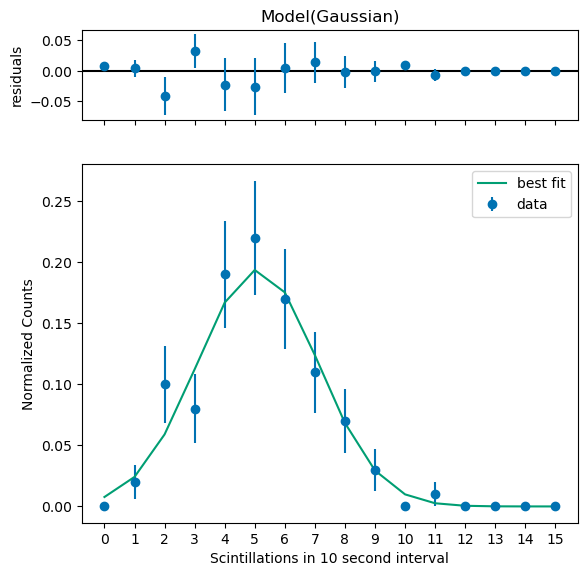

In [255]:
normalized_counting_errors[normalized_counting_errors==0] = np.inf # some big number so we dont consider them

gresult = gmodel.fit(normalized_counts, x=bin_centers, amp=1, cen=5, sigma=2, weights=np.power(normalized_counting_errors,-1))

lmfit.report_fit(gresult)
plt.figure()
gresult.plot()
plt.xlabel("Scintillations in 10 second interval")
plt.xticks(bin_centers)
plt.ylabel("Normalized Counts")
plt.show()

In [252]:
# Probability of getting a chi2 less than result_Gaussian.chisqr for our number of degrees of freedom is 
print(f"Prob(chi2 <= our value) = {chi2.cdf(gresult.chisqr , df=gresult.nfree):.3f}")
print(f"Prob(chi2 > our value) = {1-chi2.cdf(gresult.chisqr , df=gresult.nfree):.3f}")

# Our null hypothesis was that this data was drawn from a Gaussian distribution. We can only reject this statement with a confidence given by the first number below

Prob(chi2 <= our value) = 0.014
Prob(chi2 > our value) = 0.986
